# Results

In [5]:
import numpy as np
from PIL import Image
import random

from framework.VReID import VReID
from framework.util import *

In [2]:
reid = VReID()

[INFO] Visual Component Initialization
[Visual Component] model file path saved_models/visual/KPNEUMA/resnet50_model_25.pth
[Temporal Component] model file path saved_models/temporal/LSTM_500.pth
[Temporal Component] model file path saved_models/temporal/GRU_700.pth
[Temporal Component] model file path saved_models/temporal/Transformer_1300.pth


## $\alpha$ Optimization

100%|██████████| 101/101 [02:44<00:00,  1.63s/it]


Performance with model : None
Max Alpha : 0.79
mAP : 1.0000
CMC : 1.0000, 1.0000, 1.0000


100%|██████████| 101/101 [03:33<00:00,  2.12s/it]


Performance with model : LSTM
Max Alpha : 0.23
mAP : 0.9342
CMC : 0.8899, 0.9780, 0.9906


100%|██████████| 101/101 [03:34<00:00,  2.12s/it]


Performance with model : GRU
Max Alpha : 0.22
mAP : 0.9486
CMC : 0.9151, 0.9811, 0.9906


100%|██████████| 101/101 [03:33<00:00,  2.12s/it]


Performance with model : Transformer
Max Alpha : 0.25
mAP : 0.9404
CMC : 0.9025, 0.9811, 0.9906


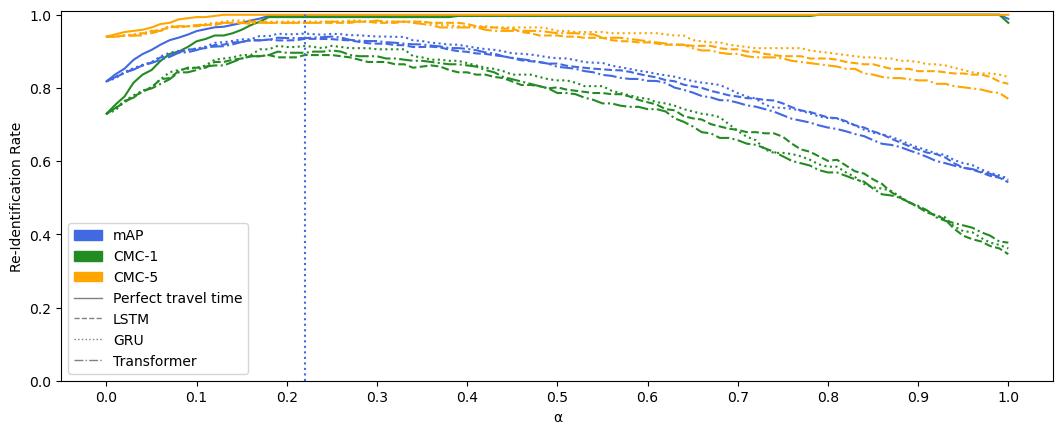

In [3]:
temporal_models_to_eval =  [None, "LSTM", "GRU", "Transformer"] # ["GRU"]

reid.alpha_evaluate(temporal_models_to_eval, dynamic=True, gt_vlds=False, metrics=["mAP", "CMC-1", "CMC-5"], title="Proposed Framework Performance", logging=True)
#reid.alpha_evaluate(temporal_models_to_eval, dynamic=True, gt_vlds=True, metrics=["mAP", "CMC-1", "CMC-5"] , title="Proposed Framework Performance with OD Information", logging=True)

## Top-k : Visual vs Framework

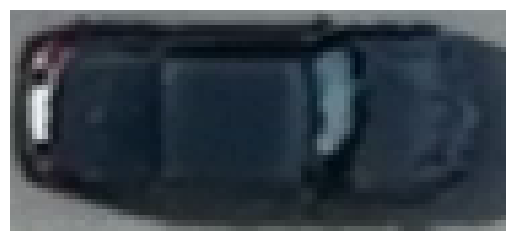

[Top-5] ReIDed Vehicles with Baseline
Rank 1 : Vehicle 01000108 with distance 0.4799776077270508


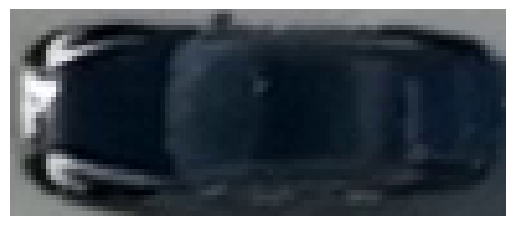

Rank 2 : Vehicle 01000198 with distance 0.4935174584388733


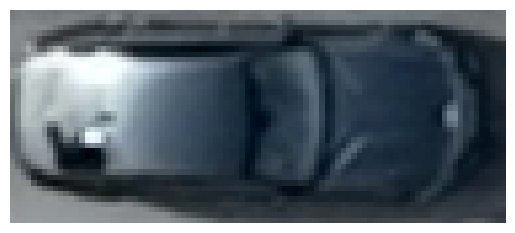

Rank 3 : Vehicle 01000069 with distance 0.527925968170166


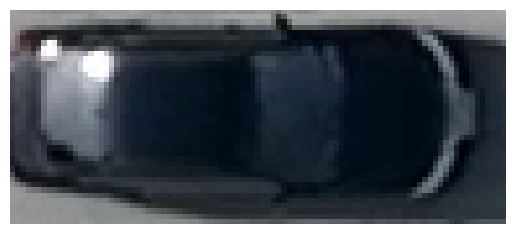

Rank 4 : Vehicle 01000066 with distance 0.5806320309638977


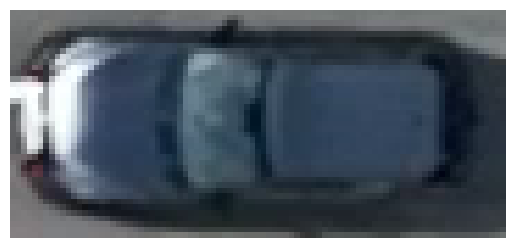

Rank 5 : Vehicle 01000210 with distance 0.5999171733856201


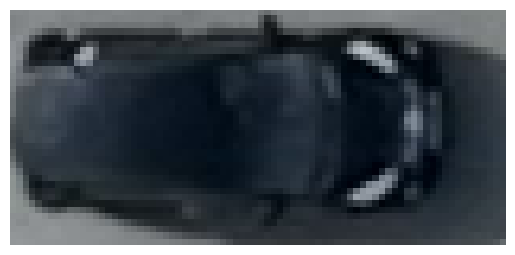

[Top-5] ReIDed Vehicles with Proposed Framework
Rank 1 : Vehicle 01000198 with distance 0.4799776077270508


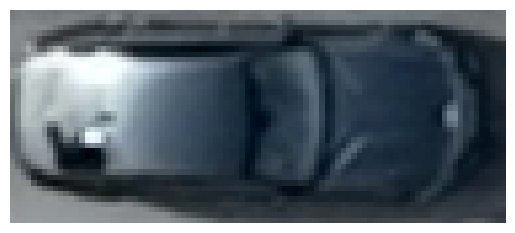

Rank 2 : Vehicle 01000108 with distance 0.4935174584388733


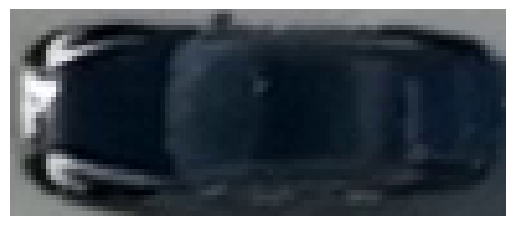

Rank 3 : Vehicle 01000166 with distance 0.527925968170166


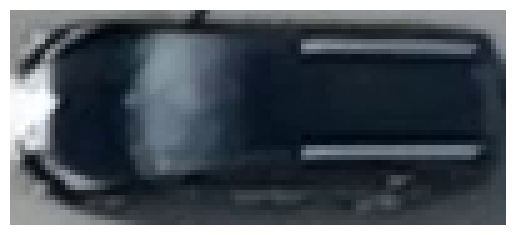

Rank 4 : Vehicle 01000069 with distance 0.5806320309638977


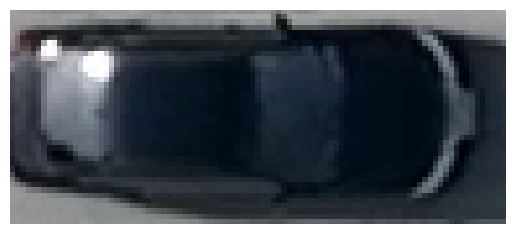

Rank 5 : Vehicle 01000179 with distance 0.5999171733856201


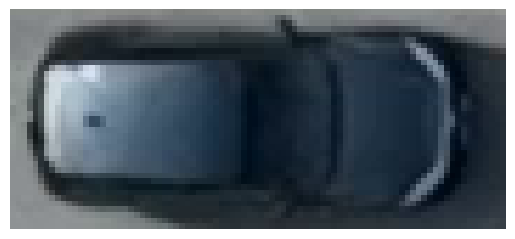

In [6]:
distmat_visual = reid.get_distmat_visual()
assigned_g_pids = np.array([reid.g_pids[ordered_idx] for ordered_idx in np.argsort(distmat_visual, axis=1)])
_, _, assigned_g_pids_fw = reid.evaluate(temp_alpha=0.22, temporal_model_name="GRU", dynamic=True, gt_vlds=False, logging=False, return_assignment=True)

# Sample Vehicle ID where the framework classifies correctly but the visual ReID does not
flag = False
while(flag is False):
    q_pid_idx = random.choice(range(len(reid.q_pids)))
    q_pid = reid.q_pids[q_pid_idx]
    top_k_g_pids = assigned_g_pids[q_pid_idx, :5]
    top_k_g_pids_fw = assigned_g_pids_fw[q_pid_idx, :5]
    flag = top_k_g_pids[0] != q_pid and top_k_g_pids_fw[0] == q_pid

# Visualize the query image
q_img = np.array(Image.open([_ for _ in reid.visual.query_fp if q_pid in _][0]))
show_image_inline(q_img, bgr2rgb=False, axis_off=True)

# Visualiaze the top-k gallery images
print("[Top-5] ReIDed Vehicles with Baseline")
for r, g_pid in enumerate(top_k_g_pids):
    g_img = np.array(Image.open([_ for _ in reid.visual.gallery_fp if g_pid in _][0]))
    print(f"Rank {r+1} : Vehicle {g_pid} with distance {np.sort(distmat_visual[q_pid_idx])[r]}")
    show_image_inline(g_img, bgr2rgb=False, axis_off=True)

# Visualiaze the top-k gallery images
print("[Top-5] ReIDed Vehicles with Proposed Framework")
for r, g_pid in enumerate(top_k_g_pids_fw):
    g_img = np.array(Image.open([_ for _ in reid.visual.gallery_fp if g_pid in _][0]))
    print(f"Rank {r+1} : Vehicle {g_pid} with distance {np.sort(distmat_visual[q_pid_idx])[r]}")
    show_image_inline(g_img, bgr2rgb=False, axis_off=True)

## Temporal Component Performance

['[TEMPORAL COMPONENT] Travel Time Distributions : Train & Test']


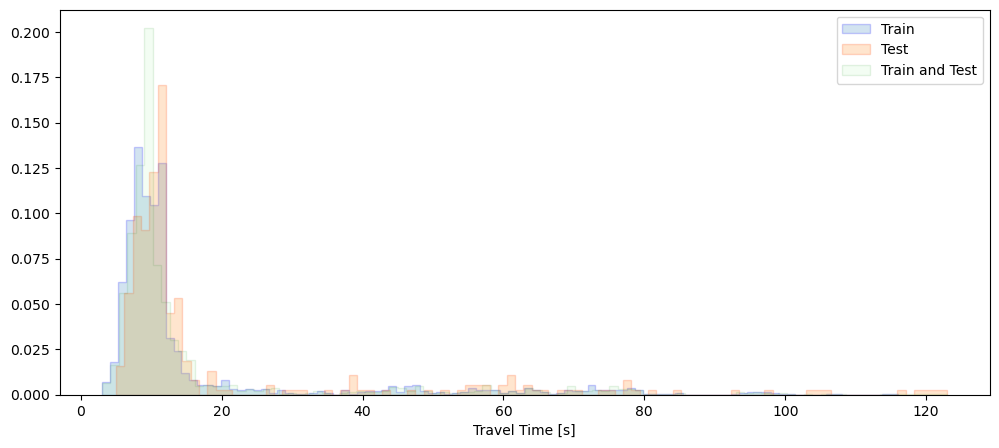

[TEMPORAL COMPONENT] Travel Time Prediction Performance
#############################################################
LSTM Model RMSE : 10.65 sec
LSTM Model MAE : 3.45 sec


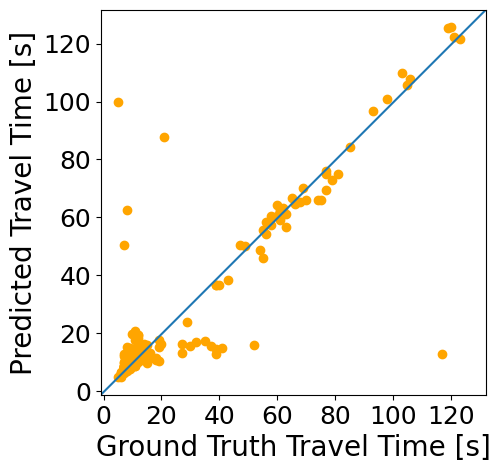

Error Distribution for LSTM : mu=0.01233151873702523, sigma=10.652557945636044


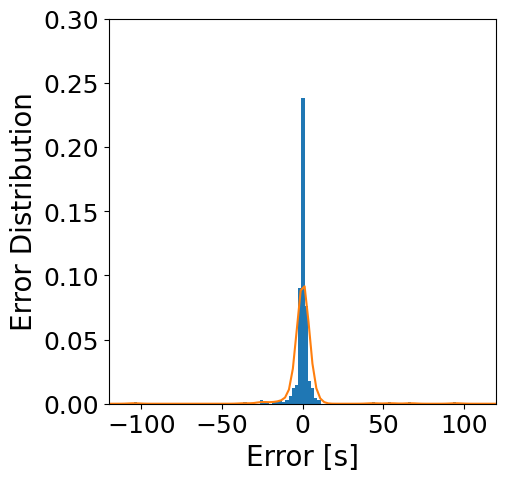

#############################################################
GRU Model RMSE : 10.23 sec
GRU Model MAE : 3.22 sec


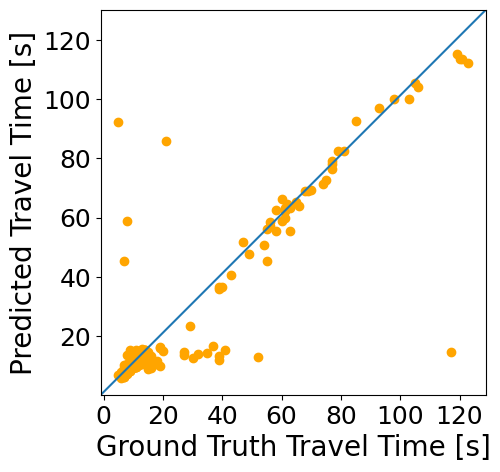

Error Distribution for GRU : mu=-0.06008754136427393, sigma=10.231177643333455


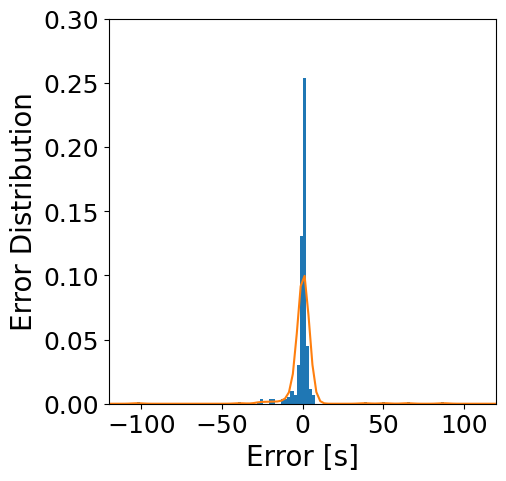

#############################################################
Transformer Model RMSE : 10.24 sec
Transformer Model MAE : 3.5 sec


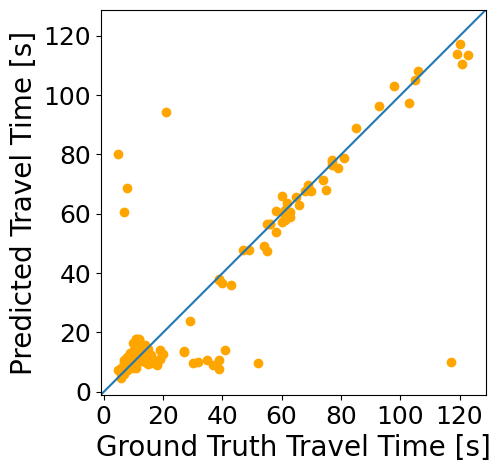

Error Distribution for Transformer : mu=-0.5947941444205038, sigma=10.301456958352203


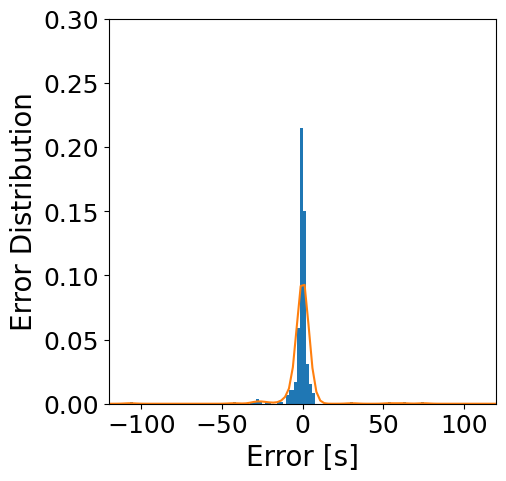

#############################################################
baseline Model RMSE : 12.63 sec
baseline Model MAE : 5.8 sec


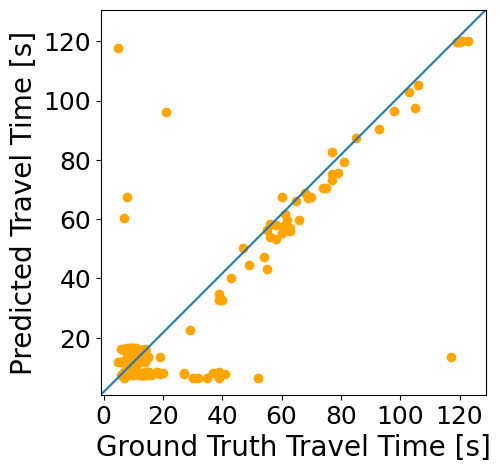

Error Distribution for baseline : mu=0.9136125637358864, sigma=12.595520238463388


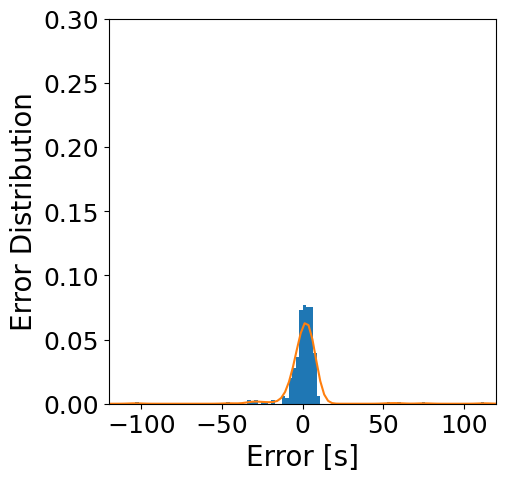

In [7]:
print(["[TEMPORAL COMPONENT] Travel Time Distributions : Train & Test"])
reid.temporal.visualize_histogram_temporal_data()

# RMSE & MAE Evaluation & Scatter & Error Histogram
print("[TEMPORAL COMPONENT] Travel Time Prediction Performance")
for model in ["LSTM", "GRU", "Transformer", "baseline"]:
    print("#############################################################")
    for metric in ["RMSE", "MAE"]:
        print(f"{model} Model {metric} : {np.round(reid.temporal.evaluate(model, metric=metric), 2)} sec")
    
    # SCATTER PLOT : GT vs PREDICTED : TEST DATA
    reid.temporal.visualize_scatter_gts_preds(model)
    # ERROR HISTOGRAM : TEST DATA
    reid.temporal.visualize_histogram_errors(model)